# Concrete Strength Prediction

## 1.0 Objective
To predict the concrete strength using the data available in file concrete_data.xls. Apply feature engineering and model tuning to obtain 85% to 95% accuracy. The concrete compressive strength is the regression problem. 

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
from scipy import stats

fig = plt.gcf()
fig.set_size_inches(16, 8)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import seaborn as sns; sns.set()
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.tree import DecisionTreeRegressor

<Figure size 1152x576 with 0 Axes>

## 2.0 Data

Description of features and target variables :

* Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
* Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
* Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
* Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
* Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
* Age(age) -- quantitative -- Day (1~365) -- Input Variable
* Concrete compressive strength(strength) -- quantitative -- MPa -- Output Variable

In [2]:
df = pd.read_csv('concrete.csv')

In [3]:
df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


#### 2.1 Shape

In [4]:
df.shape

(1030, 9)

#### 2.2 Variables

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


#### 2.3 Data description

In [6]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### 2.4 Missing values

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## 3.0 EDA

#### 3.1 Univariate Analysis

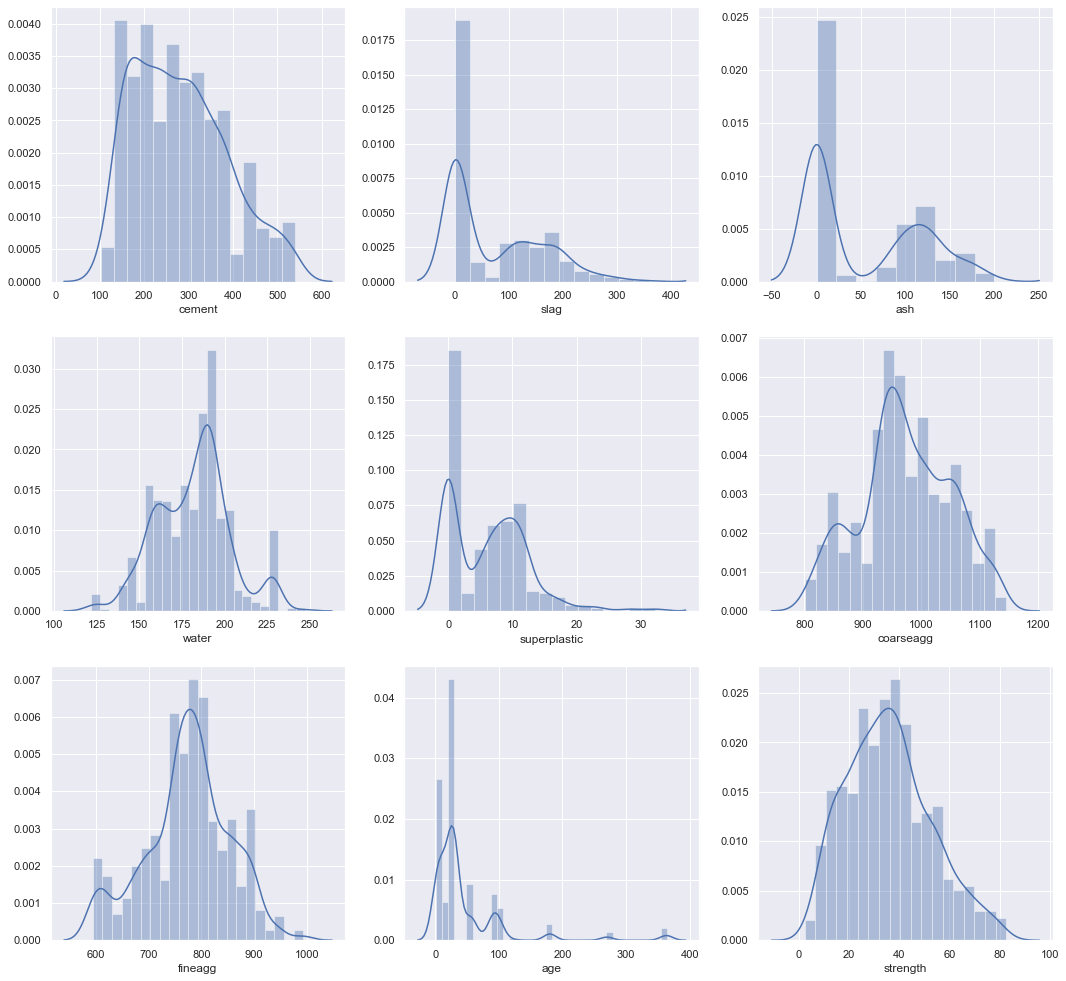

In [130]:
fig, ax2 = plt.subplots(3, 3, figsize=(16, 16))
sns.distplot(df['cement'],ax=ax2[0][0])
sns.distplot(df['slag'],ax=ax2[0][1])
sns.distplot(df['ash'],ax=ax2[0][2])
sns.distplot(df['water'],ax=ax2[1][0])
sns.distplot(df['superplastic'],ax=ax2[1][1])
sns.distplot(df['coarseagg'],ax=ax2[1][2])
sns.distplot(df['fineagg'],ax=ax2[2][0])
sns.distplot(df['age'],ax=ax2[2][1])
sns.distplot(df['strength'],ax=ax2[2][2])

#### The univariate distribution of the predictor and target variables shows that the slag, ash, superplastic and age exhibit skweness and possible outlier. These variables are further analysed.

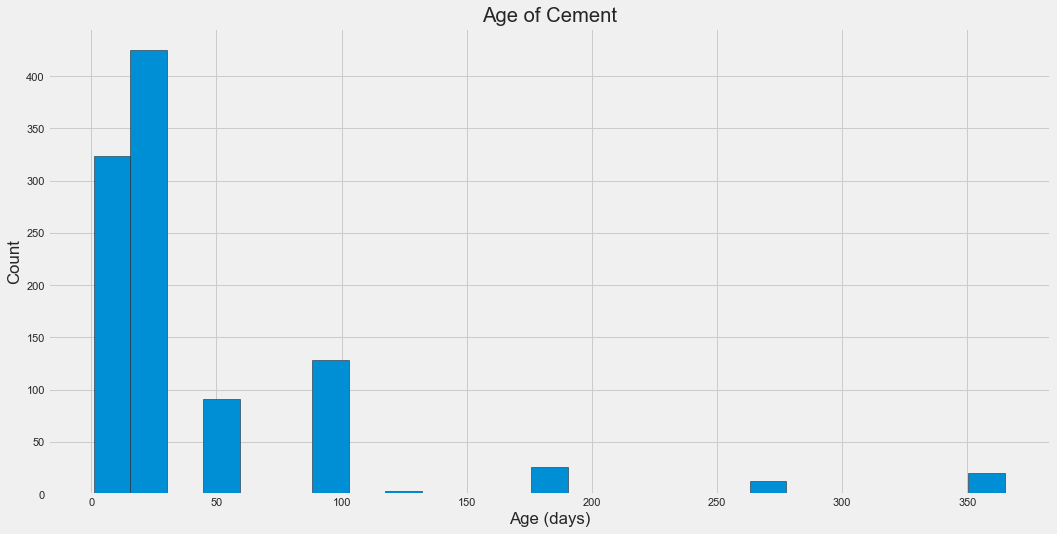

In [10]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
# Plot the distribution of ages in years
plt.hist(df['age'], edgecolor = 'k', bins = 25)
plt.title('Age of Cement'); plt.xlabel('Age (days)'); plt.ylabel('Count');

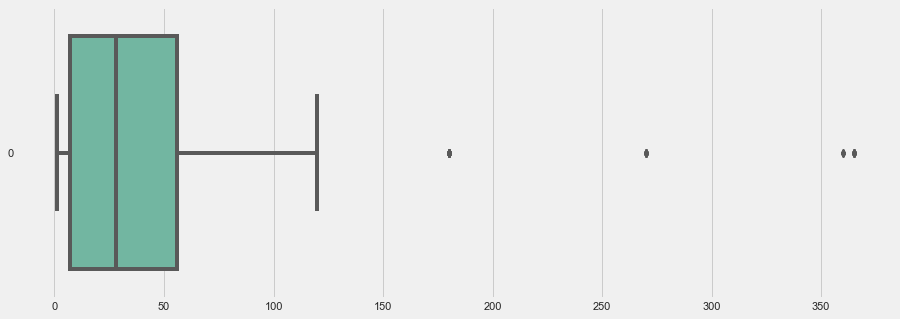

In [11]:
plt.figure(figsize=(14, 5))
ax = sns.boxplot(data=df['age'], orient="h", palette="Set2")

In [120]:
#Quartiles
Q1=df['age'].quantile(q=0.25)
Q3=df['age'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['age']))

1st Quartile (Q1) is:  7.0
3st Quartile (Q3) is:  56.0
Interquartile range (IQR) is  49.0


In [129]:
Q1=df['age'].quantile(q=0.25)
Q3=df['age'].quantile(q=0.75)
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Number of outliers in slag upper : ', df[df['age']>U_outliers]['age'].count())
print('Number of outliers in slag lower : ', df[df['age']<L_outliers]['age'].count())

Number of outliers in slag upper :  59
Number of outliers in slag lower :  0


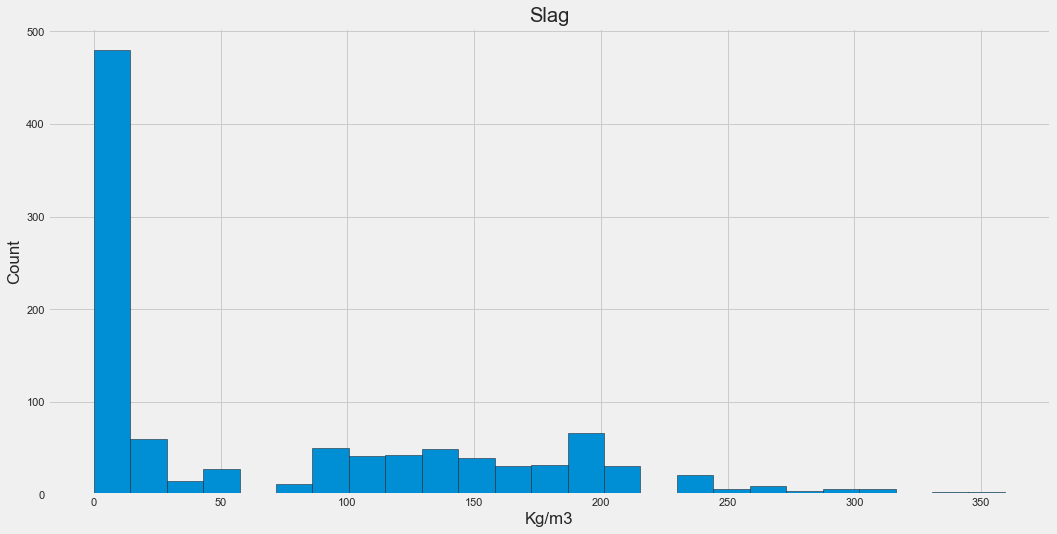

In [12]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
# Plot the distribution of ages in years
plt.hist(df['slag'], edgecolor = 'k', bins = 25)
plt.title('Slag'); plt.xlabel('Kg/m3'); plt.ylabel('Count');

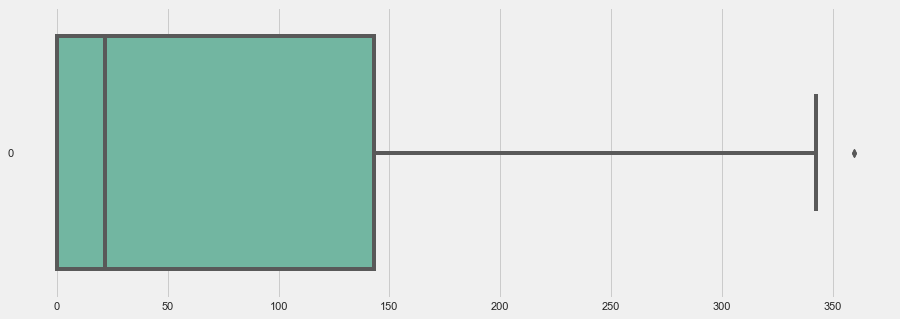

In [13]:
plt.figure(figsize=(14, 5))
ax = sns.boxplot(data=df['slag'], orient="h", palette="Set2")

In [119]:
#Quartiles
Q1=df['slag'].quantile(q=0.25)
Q3=df['slag'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['slag']))

1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  142.95
Interquartile range (IQR) is  142.95


In [126]:
Q1=df['slag'].quantile(q=0.25)
Q3=df['slag'].quantile(q=0.75)
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Number of outliers in slag upper : ', df[df['slag']>U_outliers]['slag'].count())
print('Number of outliers in slag lower : ', df[df['slag']<L_outliers]['slag'].count())

Number of outliers in slag upper :  2
Number of outliers in slag lower :  0


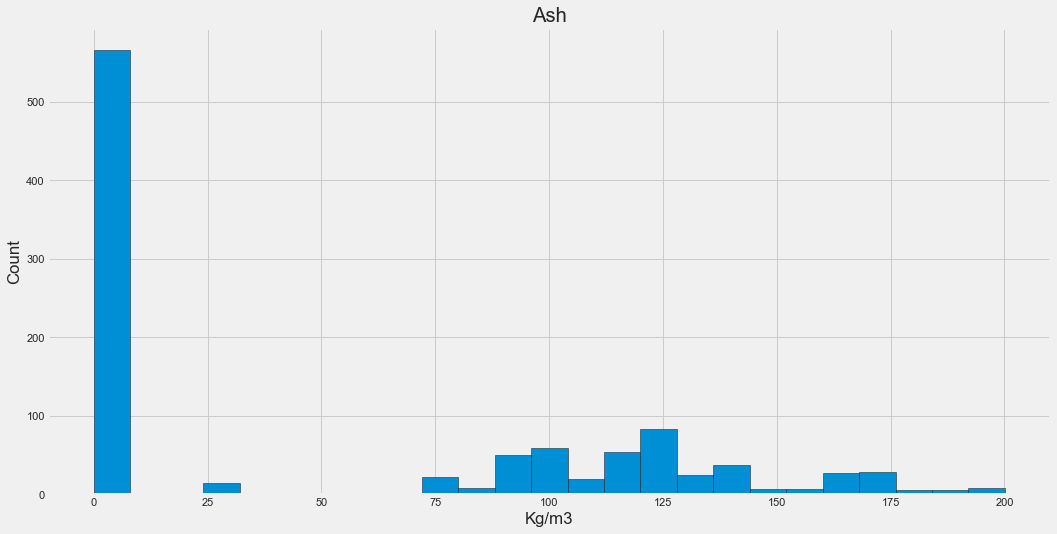

In [14]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
# Plot the distribution of ages in years
plt.hist(df['ash'], edgecolor = 'k', bins = 25)
plt.title('Ash'); plt.xlabel('Kg/m3'); plt.ylabel('Count');

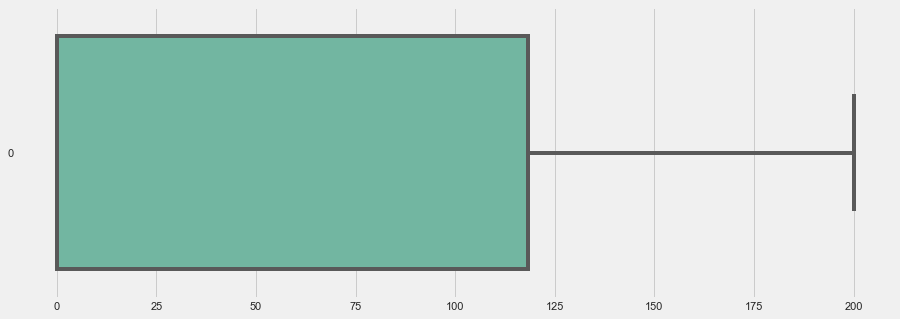

In [15]:
plt.figure(figsize=(14, 5))
ax = sns.boxplot(data=df['ash'], orient="h", palette="Set2")

In [118]:
#Quartiles
Q1=df['ash'].quantile(q=0.25)
Q3=df['ash'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['ash']))

1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  118.3
Interquartile range (IQR) is  118.3


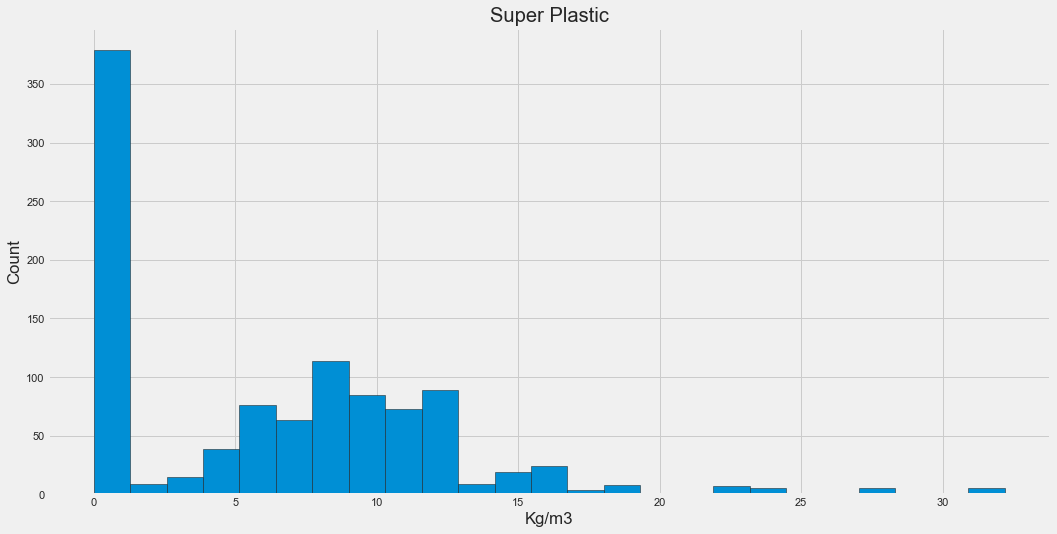

In [16]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
# Plot the distribution of ages in years
plt.hist(df['superplastic'], edgecolor = 'k', bins = 25)
plt.title('Super Plastic'); plt.xlabel('Kg/m3'); plt.ylabel('Count');

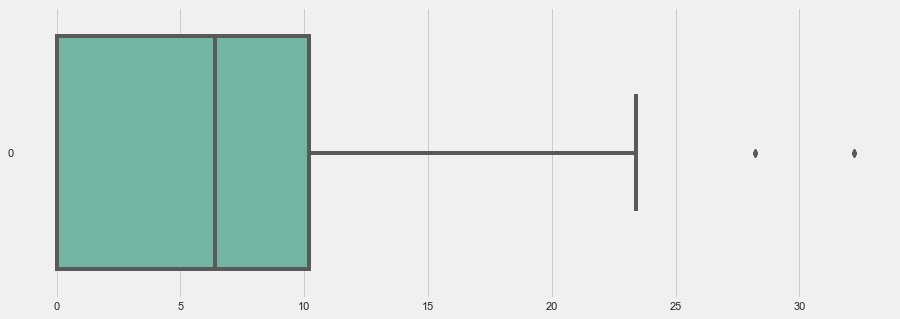

In [17]:
plt.figure(figsize=(14, 5))
ax = sns.boxplot(data=df['superplastic'], orient="h", palette="Set2")

In [117]:
#Quartiles
Q1=df['superplastic'].quantile(q=0.25)
Q3=df['superplastic'].quantile(q=0.75)
print('1st Quartile (Q1) is: ', Q1)
print('3st Quartile (Q3) is: ', Q3)
print('Interquartile range (IQR) is ', stats.iqr(df['superplastic']))

1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  10.2
Interquartile range (IQR) is  10.2


In [128]:
Q1=df['superplastic'].quantile(q=0.25)
Q3=df['superplastic'].quantile(q=0.75)
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Number of outliers in slag upper : ', df[df['superplastic']>U_outliers]['superplastic'].count())
print('Number of outliers in slag lower : ', df[df['superplastic']<L_outliers]['superplastic'].count())

Number of outliers in slag upper :  10
Number of outliers in slag lower :  0


#### 3.2 bivariate Analysis

In [18]:
corr = df.corr()
corr

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplastic,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseagg,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineagg,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


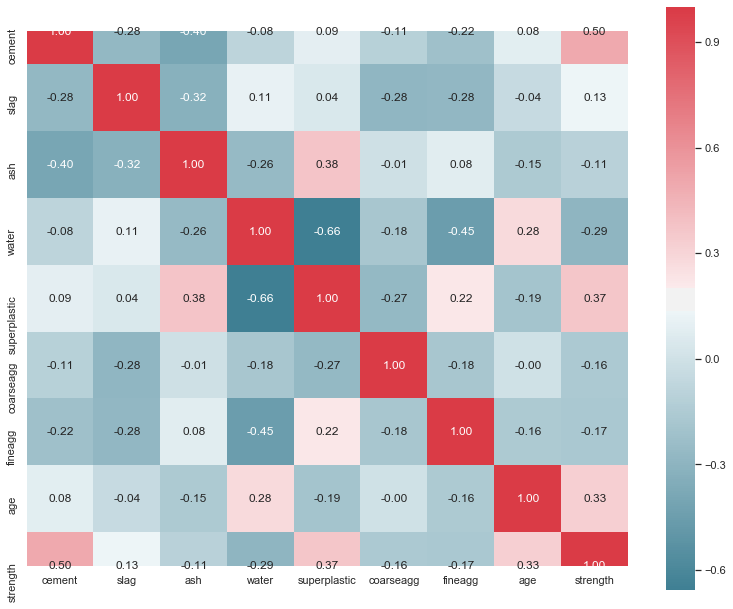

In [69]:
f, ax = plt.subplots(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', mask=np.zeros_like(corr, dtype=np.bool),
           cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True,ax=ax)

The correlation matrix shows high positive correlation between `Strength` and `Cement`. This is expected because concrete strength  indeed increases with an increase in the amount of cement used in preparing it. Also, `Age` and `Superplastic` are the other two factors influencing strength. There are other strong correlations between the features;

* A strong negative correlation between `Superplastic` and `Water`.
* Positive correlations between `Superplastic` and Ash, Fine Aggregate.

We can explore these relationships by looking at a `pairplot` and some `scatter plots`.

#### Pair  plot

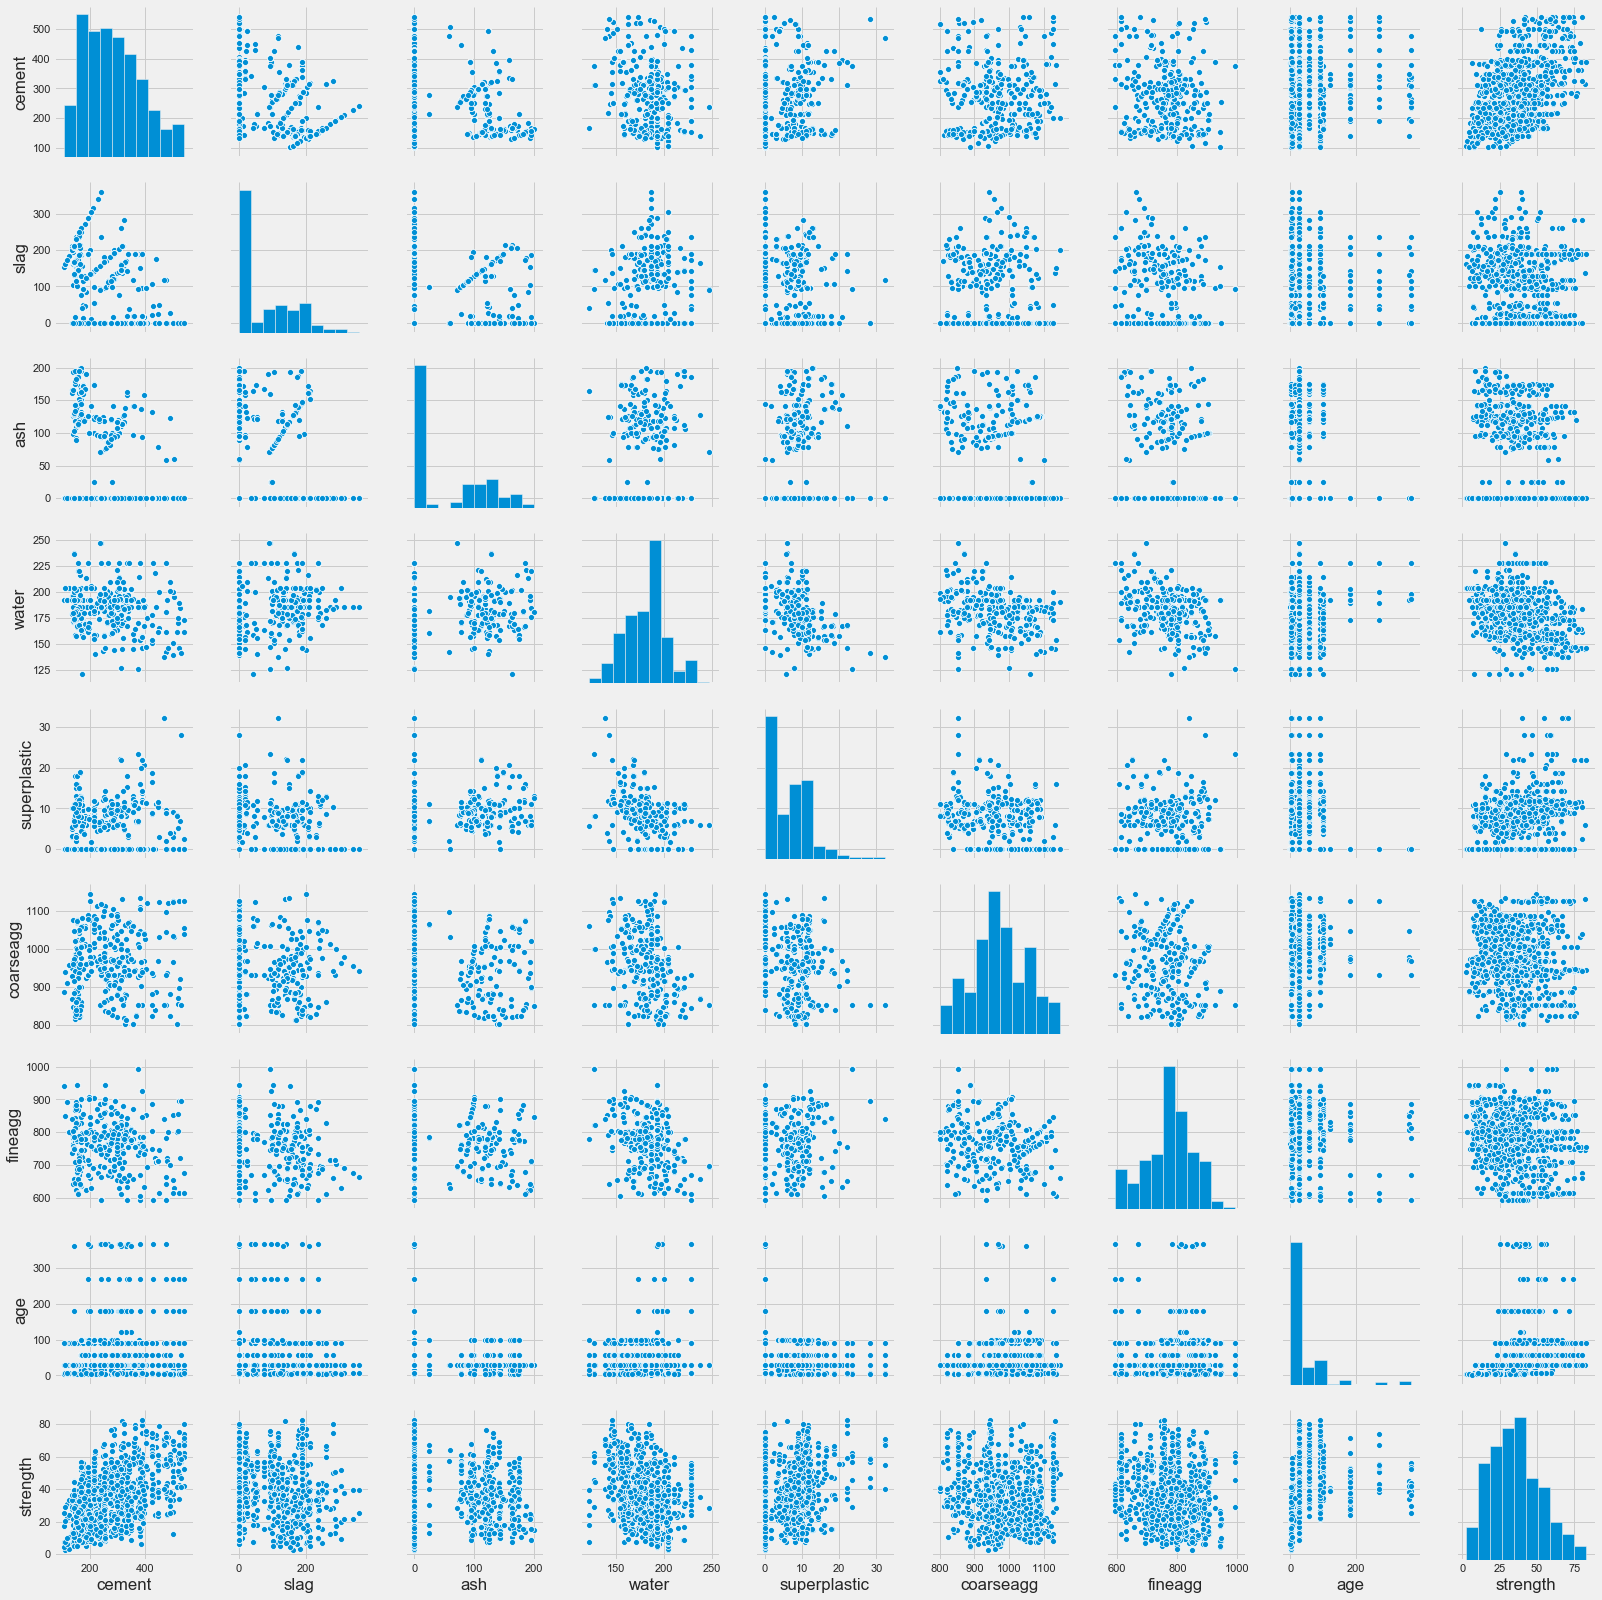

In [20]:
sns.pairplot(df);

#### scatter plots

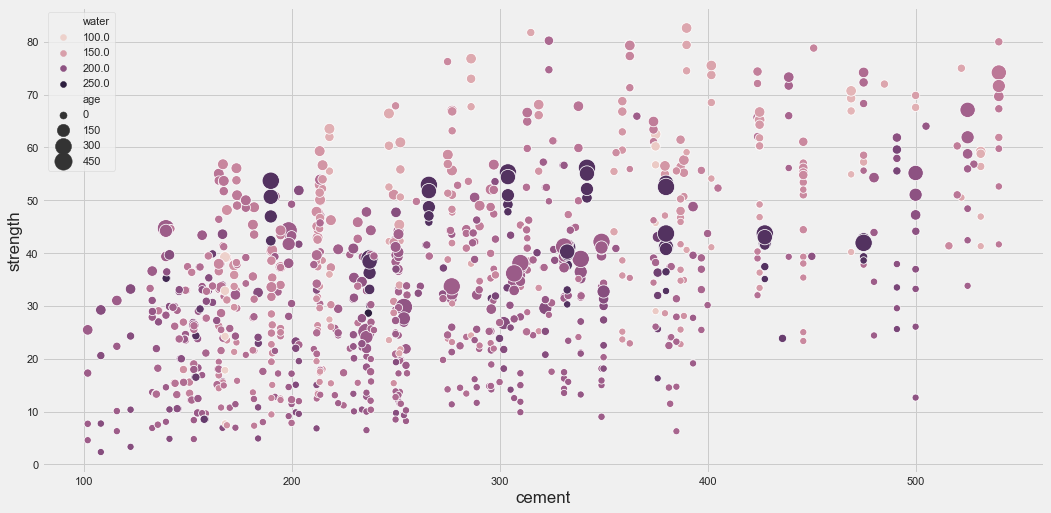

In [21]:
plt.figure(figsize=(16, 8))
ax = sns.scatterplot(y="strength", x="cement", hue="water",size="age", data=df,  sizes=(50, 300));


The scatter plot shows the following;

* Strength increases as the amount of cement increases, which shows a strong positive correlation.
* Strength increases with age which is represented by the black cirlce size. However, some cement with less number of age (days) also may have a lower strenght.
* The lower the age, the more cement content is required for increase strength.
* Cement with less water shows an increase in strength.

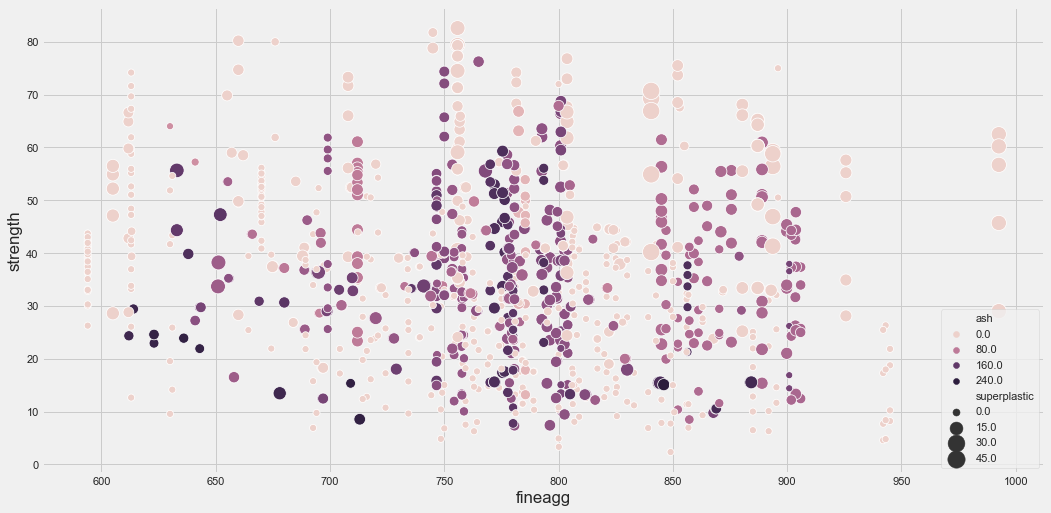

In [22]:
plt.figure(figsize=(16, 8))
sns.scatterplot(y="strength", x="fineagg", hue="ash",
   size="superplastic", data=df,  sizes=(50, 300));

We observe the following;

* A decrease in strength  as the ash content increases.
* Strength increases with superplastic even though the relation is weak.

## 4.0 Data Preprocessing

#### 4.1 Removing outliers

In [133]:
df_processed = df

In [134]:
#Replacing the outliers by median
for col_name in df_processed.columns[:-1]:
    q1 = df_processed[col_name].quantile(0.25)
    q3 = df_processed[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    df_processed.loc[(df_processed[col_name] < low) | (df_processed[col_name] > high), col_name] = df_processed[col_name].median()

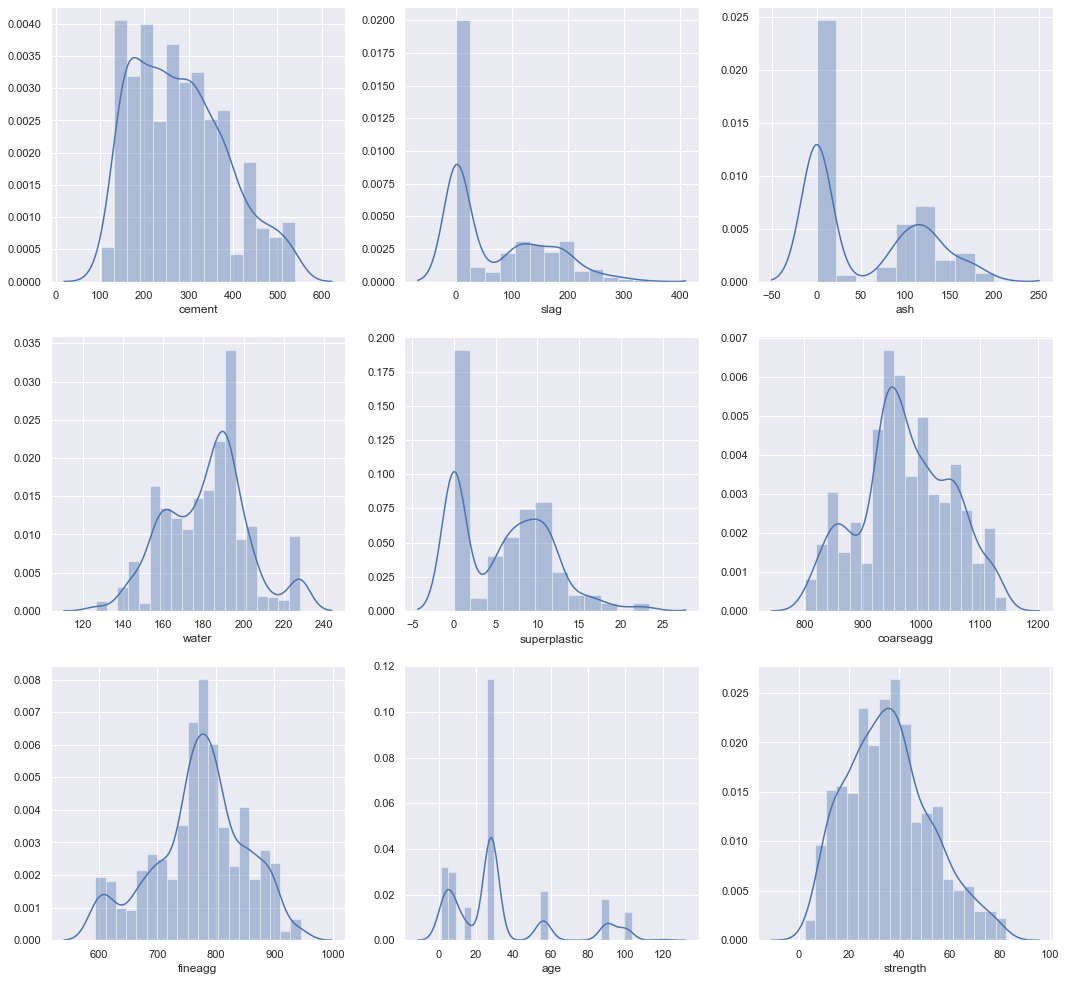

In [136]:
fig, ax2 = plt.subplots(3, 3, figsize=(16, 16))
sns.distplot(df_processed['cement'],ax=ax2[0][0])
sns.distplot(df_processed['slag'],ax=ax2[0][1])
sns.distplot(df_processed['ash'],ax=ax2[0][2])
sns.distplot(df_processed['water'],ax=ax2[1][0])
sns.distplot(df_processed['superplastic'],ax=ax2[1][1])
sns.distplot(df_processed['coarseagg'],ax=ax2[1][2])
sns.distplot(df_processed['fineagg'],ax=ax2[2][0])
sns.distplot(df_processed['age'],ax=ax2[2][1])
sns.distplot(df_processed['strength'],ax=ax2[2][2])

#### 4.2 Data normalization

In [137]:
#Normalize data
ndata = normalize(df_processed,axis = 1)
ndata = pd.DataFrame(ndata, columns=df.columns)

In [138]:
ndata

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,0.111269,0.166942,0.000000,0.160249,0.000000,0.765257,0.589416,0.022049,0.023537
1,0.123388,0.030829,0.090806,0.115645,0.007890,0.789569,0.581657,0.010228,0.017175
2,0.188137,0.000000,0.072019,0.141027,0.004139,0.720111,0.648093,0.021071,0.021989
3,0.220434,0.094472,0.000000,0.188944,0.000000,0.772349,0.555229,0.023204,0.037996
4,0.119480,0.141555,0.000000,0.149196,0.007024,0.808423,0.537739,0.021611,0.014117
...,...,...,...,...,...,...,...,...,...
1025,0.105072,0.000000,0.129200,0.140096,0.007783,0.747959,0.626542,0.021793,0.010344
1026,0.392865,0.000000,0.000000,0.104853,0.004732,0.630077,0.660838,0.002218,0.030539
1027,0.227165,0.095337,0.074215,0.147608,0.007315,0.715110,0.631444,0.023012,0.036392
1028,0.280015,0.031113,0.000000,0.186676,0.000000,0.763081,0.548567,0.022925,0.045081


### 4.1 Feature Engineering

The correlations between predictive features are all lower that 0.5, the effect of multicollinarity is not significant. Therefore no feature is dropped.

# 5.0 Model Building

In [150]:
#subsetting the data
x = ndata.iloc[:,0:8]
y = ndata.iloc[:,8]


In [151]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.3,random_state = 3)
print(ytrain.shape)
print(ytest.shape)

(721,)
(309,)


### 5.1 Base model
A `simple` linear regression model will be used as the `base model`.

In [152]:
lm = LinearRegression()
model = lm.fit(xtrain,ytrain)
pred = model.predict(xtrain)
accuracy = r2_score(pred,ytrain)
print("Accuracy of Multiple Regression on training set:",end='')
print(accuracy)

Accuracy of Multiple Regression on training set:0.6040257630873811


In [153]:
predt = model.predict(xtest)
taccuracy = r2_score(predt,ytest)
print("Accuracy of Multiple Regression on test set:",end='')
print(taccuracy)

Accuracy of Multiple Regression on test set:0.5917596757794229


The r2 score is almost the same in train and test data. The model can only explain about 60% of the repaltion between the predictors and target variable. A better model is therefore, needed.

### 5.2 Polynomial regression

We try to increase the complexity of the model by using quadratic polynomials of the predictors.

In [229]:
poly = PolynomialFeatures(degree = 2)
xpoly = poly.fit_transform(xtrain)
model_3 = lm.fit(xpoly,ytrain)
pred = lm.predict(xpoly)
taccuracy = r2_score(pred,ytrain)
print("Accuracy of training set of degree 2 polynomial:",end='')
print(taccuracy)

Accuracy of training set of degree 2 polynomial:0.9683533268788145


In [230]:
xpoly = poly.fit_transform(xtest)
pred = lm.predict(xpoly)
ttaccuracy = r2_score(pred,ytest)
print("Accuracy of testing set of degree 2 polynomial:",end='')
print(ttaccuracy)

Accuracy of testing set of degree 2 polynomial:0.9730071415825421


The model perfom=rms better and does not show signs of overfitting.

### 5.3 Other models

In [188]:
Model = []
RMSE = []
R_sq = []
cv = KFold(10, random_state = 1)

C:\Users\Charles.Sambo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [189]:
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
          'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor']
models = [LinearRegression(), Ridge(), Lasso(),
          DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor()]


In [190]:
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [191]:
for name, model in zip(model_names, models):
    input_scores(name, model, xtrain, ytrain)

In [192]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
evaluation

,Model,RMSE,R Squared
0,Linear Regression,0.006936,0.708203
1,Ridge Regression,0.009396,0.464419
2,Lasso Regression,0.012866,-0.005116
3,Decision Tree Regressor,0.005912,0.775778
4,Random Forest Regressor,0.004345,0.886184
5,Gradient Boosting Regressor,0.004355,0.884158
6,Adaboost Regressor,0.006053,0.774560


### 5.3 Hyperparameter tunning

#### 5.3.1 Random Forest

In [202]:
rf = RandomForestRegressor()

In [227]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 300],
    'max_features': [2, 3, 5, 8],
    'min_samples_leaf': [3, 4, 5, 8],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1027 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1999 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2606 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3295 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4064 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  6.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [228]:
print(" Best cross-validation accuracy: {:.2f}". format( grid_search.best_score_)) 
print(" Best parameters: ", grid_search.best_params_) 
print(" Test set accuracy: {:.2f}". format( grid_search.score( xtest, ytest)))

 Best cross-validation accuracy: 0.87
 Best parameters:  {'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
 Test set accuracy: 0.87


#### 5.3.2 Gradient Boosting

In [219]:
def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()  
    #cv = ShuffleSplit(xtrain.shape[0], n_splits=10, test_size=0.2) 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 
    classifier.fit(xtrain, ytrain) 
    print ("Best Estimator learned through GridSearch")
    print (classifier.best_estimator_ )
    return cv, classifier.best_estimator_ , classifier


In [220]:
n_jobs = -1
param_grid={'n_estimators':[100], 
            'learning_rate': [0.1],# 0.05, 0.02, 0.01], 
            'max_depth':[6],#4,6], 
            'min_samples_leaf':[3],#,5,9,17], 
            'max_features':[1.0]} 

In [221]:
cv,best_est, grid = GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [222]:
print(" Best cross-validation accuracy: {:.2f}". format( grid.best_score_)) 
print(" Best parameters: ", grid.best_params_) 
print(" Test set accuracy: {:.2f}". format(grid.score( xtest, ytest)))


 Best cross-validation accuracy: 0.90
 Best parameters:  {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 100}
 Test set accuracy: 0.89


# 6.0 Conclusion

The following is concluded:

* Random forest and gradient boosting models are the top performing models are the best perfoming models before hyperparemeter tunning. 
* Gradinet boosting is the final selected model after hyperparameter tunning squeezing out an extra 1% accuracy.
* Even if the polynomial regression model also performs very well.

#### Other refinement

Check parameter importance and drop variables which are not important